# **E-commerce Data Analysis**

---

## Introduction 
A comprehensive analysis of the Target Sales Dataset using SQL and Python. The analysis focuses on extracting insights and answering 14 business-critical questions, ranging from basic to advanced queries.

## Highlights
- Dataset: Target E-commerce Sales Dataset.
- Tools Used: MySQL, Python (with libraries like Pandas, Matplotlib, and Seaborn).
- Structure: Queries divided into three categories: Basic, Intermediate, and Advanced.

## About Dataset

Target is a globally recognized brand and a leading retailer in the United States, known for offering exceptional value, inspiration, innovation, and a unique shopping experience.

This dataset focuses on Target's operations in Brazil, covering 100,000 orders placed between 2016 and 2018. It includes detailed information on order status, pricing, payment and shipping performance, customer locations, product attributes, and customer reviews.

## Features

The data is available in 8 csv files : [Download dataset](https://www.kaggle.com/datasets/devarajv88/target-dataset?select=products.csv)

- customers.csv
- sellers.csv
- order_items.csv
- geolocation.csv
- payments.csv
- orders.csv
- products.csv

The dataset includes transaction records, customer demographics, and product details from an e-commerce platform.

## Dataset Schema

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F15074417%2Fb15a300fe807965428250762308c248b%2FUntitled.png?generation=1716400390272599&alt=media)

## Methodology

- **Data Extraction**: Retrieved data using SQL queries.
- **Data Cleaning**: Handled missing values and corrected inconsistencies.
- **Data Analysis**: Conducted exploratory data analysis using Python.
- **Visualization**: Created charts and graphs to illustrate findings.

---

**Download required libraries**

In [45]:
!pip install pandas
!pip instatll numpy
!pip install matplotlib
!pip install seaborn
!pip install mysql-connector-python

#In my case i already have these libraries installed that's why its returning "Requirement already satisfied"


ERROR: unknown command "instatll" - maybe you meant "install"


**The purpose of this code is to automate the process of importing data from multiple CSV files into corresponding MySQL database tables.**

In [135]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='your_host',                 
    user='your_username',
    password='your_password',
    database='your_database'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'path_to_your_folder'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

**This code connects a Python script to a MySQL database using the mysql-connector library and creates a cursor object to execute SQL queries.**

In [135]:
#Importing all essential libraries.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector # this module is used to interact with a MySQL database.
import numpy as np


#Establish connection to the MySQL database server.

db = mysql.connector.connect(host = '127.0.01',
                             username = 'root',
                             password = '12345',
                             database = 'ecommerce')

#The cursor is used to execute SQL queries and fetch results. It acts as a pointer that allows interaction with the database.

cur = db.cursor()


---

# Questions Answered:

## Basic Queries
1. List all unique cities where customers are located.
2. Count the number of orders placed in 2017.
3. Find the total sales per category.
4. Calculate the percentage of orders that were paid in installments.
5. Count the number of customers from each state. 

## Intermediate Queries
1. Calculate the number of orders per month in 2018.
2. Find the average number of products per order, grouped by customer city.
3. Calculate the percentage of total revenue contributed by each product category.
4. Identify the correlation between product price and the number of times a product has been purchased.
5. Calculate the total revenue generated by each seller, and rank them by revenue.

## Advanced Queries
1. Calculate the moving average of order values for each customer over their order history.
2. Calculate the cumulative sales per month for each year.
3. Calculate the year-over-year growth rate of total sales.
4. Identify the top 3 customers who spent the most money in each year.

# List all the unique cities where customers are located. 

In [61]:
query = """ select distinct customer_city 
            from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["City"])

df["City"] = df["City"].str.title()

df

,City
0,Franca
1,Sao Bernardo Do Campo
2,Sao Paulo
3,Mogi Das Cruzes
4,Campinas
...,...
4114,Siriji
4115,Natividade Da Serra
4116,Monte Bonito
4117,Sao Rafael


---

# Count the number of orders placed in 2017.

In [45]:
query = """ select count(order_id) 
            from orders 
            where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

'The number of orders placed in 2017 are',data[0][0]

('The number of orders placed in 2017 are', 45101)

---

# Find the total sales per category.

In [57]:
query = """select products.product_category category, round(sum(payments.payment_value),2) sales
           from products 
           join order_items
           on products.product_id = order_items.product_id
           join payments
           on payments.order_id = order_items.order_id
           group by category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Category","Sales"])

df["Category"] = df["Category"].str.title()

df

,Category,Sales
0,Perfumery,506738.66
1,Furniture Decoration,1430176.39
2,Telephony,486882.05
3,Bed Table Bath,1712553.67
4,Automotive,852294.33
...,...,...
69,Cds Music Dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children'S Clothing,785.67
72,Pc Gamer,2174.43


---

# Calculate the percentage of orders that were paid in installments. 

In [69]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end)) / count(*) * 100 
            from payments """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments are",data[0][0]

('The percentage of orders that were paid in installments are',
 Decimal('99.9981'))

---

# Count the number of customers from each state.

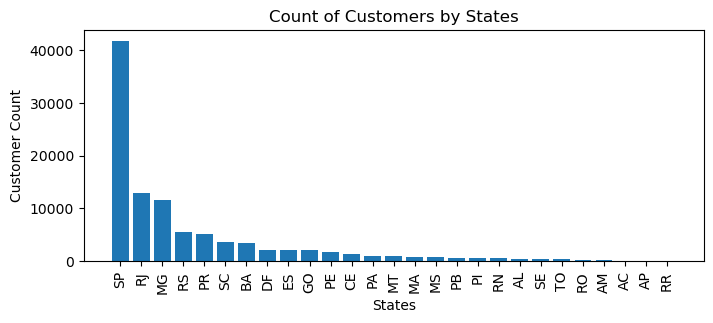

,State,Customer Count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045


In [125]:
query = """ select customer_state , count(customer_id) 
            from customers 
            group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "Customer Count" ])

df = df.sort_values(by = "Customer Count", ascending= False)

plt.figure(figsize = (8,3))

plt.bar(df["State"], df["Customer Count"])

plt.xticks(rotation = 90)

plt.xlabel("States")

plt.ylabel("Customer Count")

plt.title("Count of Customers by States")

plt.show()

df.head()

---

# Calculate the number of orders per month in 2018. 

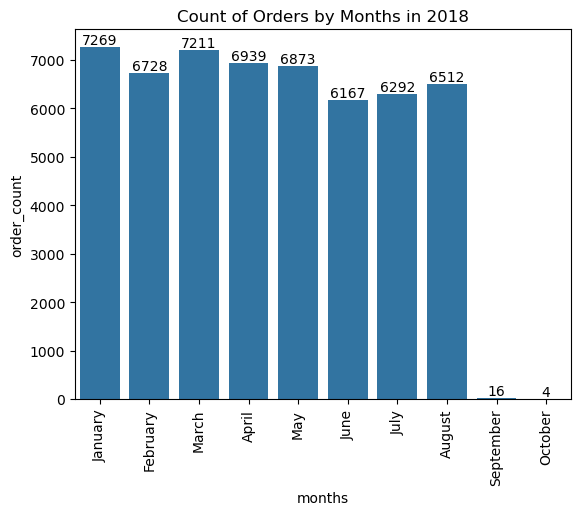

In [117]:
query = """ select monthname(order_purchase_timestamp) , count(order_id) 
            from orders 
            where year(order_purchase_timestamp) = 2018 
            group by monthname(order_purchase_timestamp) """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months","order_count"])

o = ["January", "February", "March","February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns. barplot(x = df["months"],y = df["order_count"], data = df, order = o)

plt.xticks(rotation = 90)

ax.bar_label(ax.containers[0])

plt.title("Count of Orders by Months in 2018")

plt.show()

---

# Find the average number of products per order , grouped by customer city.

In [55]:
query = """ with count_per_order as
            (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc 
            from orders 
            join order_items on orders.order_id = order_items.order_id
            group by orders. order_id, orders. customer_id)

            select customers.customer_city, round(avg(count_per_order.oc),2) average_orders 
            from customers 
            join count_per_order on customers.customer_id = count_per_order.customer_id
            group by customers. customer_city """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["City","Avg Products"])

df["City"] = df["City"].str.title()

df

,City,Avg Products
0,Sao Paulo,1.16
1,Sao Jose Dos Campos,1.14
2,Porto Alegre,1.17
3,Indaial,1.12
4,Treze Tilias,1.27
...,...,...
4105,Japaratuba,1.00
4106,Sebastiao Leal,1.00
4107,Buriti,3.00
4108,Morro Agudo De Goias,1.00


---

# Calculate the percentage of total revenue contributed by each product category. 

In [53]:
query = """select (products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from ecommerce.products 
join ecommerce.order_items
on products.product_id = order_items.product_id
join ecommerce.payments
on payments.order_id = order_items.order_id
group by category order by sales desc; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Product Category","Revenue %"])

df["Product Category"] = df["Product Category"].str.title()

df

,Product Category,Revenue %
0,Bed Table Bath,10.70
1,Health Beauty,10.35
2,Computer Accessories,9.90
3,Furniture Decoration,8.93
4,Watches Present,8.93
...,...,...
69,House Comfort 2,0.01
70,Cds Music Dvds,0.01
71,Pc Gamer,0.01
72,Fashion Children'S Clothing,0.00


---

# Identify the correlation between product price and the number of times a product has been purchased.

In [93]:
query = """ select products.product_category,
            count(order_items.order_item_id) as sold_products_cnt,
            round(avg(order_items.price),2) as avg_price
            from products
            join order_items on products.product_id = order_items.product_id
            group by products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Product Category","Number of times Products Sold","Avg Price"])

arr1 = np.array(df["Number of times Products Sold"])
arr2 = np.array(df["Avg Price"])

a = np.corrcoef(arr1,arr2)

print("The correlation between product price and the number of times a product has been purchased is",a[0][-1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


---

# Calculate the total revenue generated by each seller, and rank them by revenue.

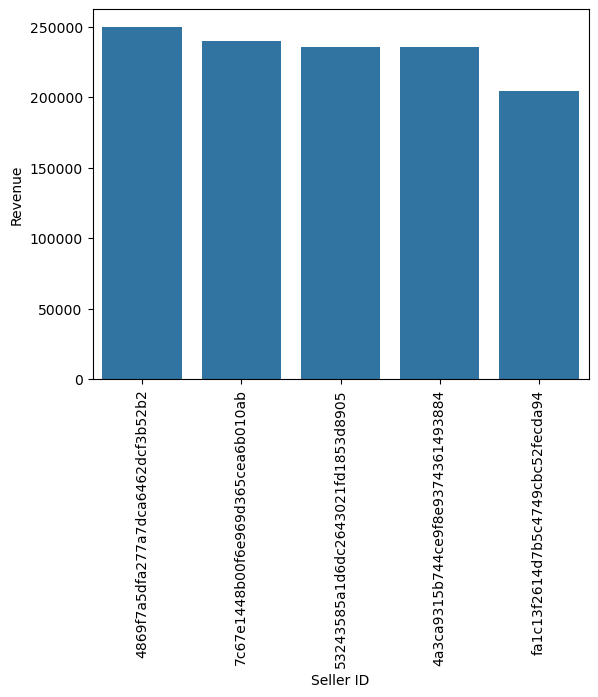

,Seller ID,Revenue,Rank
0,4869f7a5dfa277a7dca6462dcf3b52b2,249640.70,1
1,7c67e1448b00f6e969d365cea6b010ab,239536.44,2
2,53243585a1d6dc2643021fd1853d8905,235856.68,3
3,4a3ca9315b744ce9f8e9374361493884,235539.96,4
4,fa1c13f2614d7b5c4749cbc52fecda94,204084.73,5


In [121]:
query = """ select *, dense_rank() over(order by revenue desc) as rnk
            from (select seller_id,
            round(sum(price + freight_value),2) as revenue
            from order_items
            group by seller_id) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Seller ID","Revenue","Rank"])

df = df. head()

sns. barplot(x = "Seller ID", y = "Revenue", data = df)

plt.xticks(rotation = 90)

plt. show()

df.head()

---

# Calculate the moving average of order values for each customer over their order history.

In [143]:
query = """ select customer_id, 
            order_purchase_timestamp, 
            payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg 
            from (select orders.customer_id, orders.order_purchase_timestamp,
            payments.payment_value as payment from payments 
            join orders on payments. order_id = orders.order_id) as a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Customer ID","Time Stamp","Price","Moving Avg"])

df.head()


,Customer ID,Time Stamp,Price,Moving Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


---

# Calculate the cumulative sales per month for each year.

In [151]:
query = """ select years, months, payment, 
            sum(payment) over(order by years, months) cumulative_sales 
            from (select year(orders.order_purchase_timestamp) as years,
                  month(orders.order_purchase_timestamp) as months,
                  round (sum(payments.payment_value),2) as payment 
                  from orders join payments on orders.order_id = payments.order_id
                  group by years, months order by years, months) as a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["Year","Month","Sales","Cumulative Sales"])

df

,Year,Month,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


---

# Calculate the year-over-year growth rate of total sales.

In [185]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
                        round(sum(payments.payment_value),2) as payment 
                        from orders 
                        join payments on orders.order_id = payments.order_id
                        group by years 
                        order by years)

             select years, 
             ((payment - lag(payment, 1) over(order by years))/ lag(payment, 1) over(order by years)) * 100 
             from a """

cur. execute (query)

data = cur. fetchall()

df = pd.DataFrame(data , columns = ["Year","Growth Rate %"])

df

,Year,Growth Rate %
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


---

# Identify the top 3 customers who spent the most money in each year.

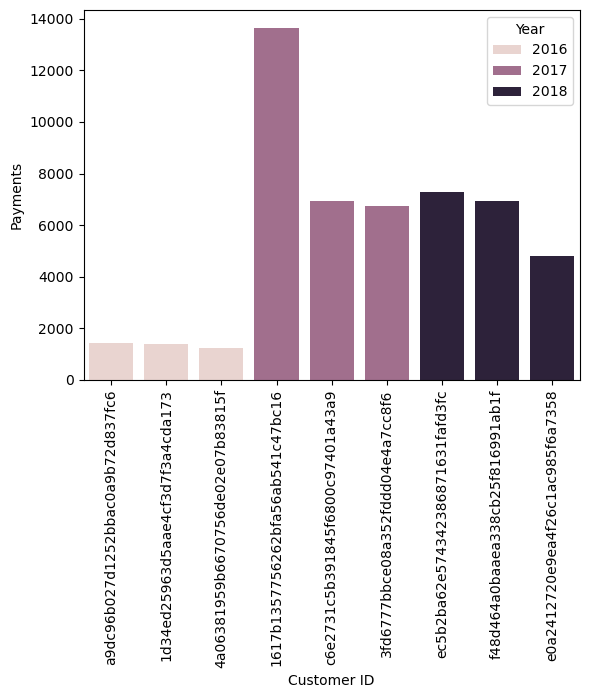

,Year,Customer ID,Payments,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


In [203]:
query = """ select years, customer_id, payment, d_rank
            from (select year(orders.order_purchase_timestamp)as years, orders.customer_id,
                  sum(payments.payment_value) as payment,
                  dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank 
                  from orders 
                  join payments on payments.order_id = orders.order_id
                  group by year(orders.order_purchase_timestamp), orders.customer_id) as a 
                  where d_rank <= 3 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Year","Customer ID","Payments","Rank"])

sns.barplot(x = "Customer ID", y = "Payments", data = df, hue = "Year")

plt.xticks(rotation = 90)

plt.show()

df

---